# Hotel Revenue Prediction

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# Read data

In [71]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/data/trans_reservation_revise.csv')
print(df.shape)
df.head()

(704640, 43)


,Reservation_Number,Name,Email,Phone_Number,Mobile,Gender,Date_of_Birth,Third_Party_Confirmation_Number,Type_of_Document,Document_Number,...,Cancelation_Date,Cancelation_fee,Origin,Property,Brand,Rating,URL,Room_Amenities,Property_Country,Property_City
0,R18010100069346,Garnett Gagliano,Garnett_Gagliano7995.allstar.ai,519144744,519144744,Un-define,1993-06-20,TP_24071621493328,Passport,MHSEMY7V,...,NaN,0,Saudi Arabia,Property 2,Brand 1,5,https://pix8.agoda.net/hotelImages/177168/-1/7...,Air conditioning: ;Closet: ;Desk: ;Free Wi-Fi ...,United States of America,Seattle
1,R20040100422523,Dagny Pawlik,Dagny_Pawlik4605.allstar.ai,408160045,408160045,Female,2012-07-12,TP_24071622154071,Passport,PE49O74I,...,NaN,0,French Guiana,Property 2,Brand 1,6,https://pix8.agoda.net/hotelImages/177168/-1/7...,Air conditioning: ;Alarm clock: ;Closet: ;Clot...,United States of America,Seattle
2,R18020100555640,Doris Diangelo,Doris_Diangelo1369.allstar.ai,346196913,346196913,Female,2022-03-26,TP_24071621597238,Passport,9IW0W5QT,...,NaN,0,Guatemala,Property 2,Brand 1,8,https://pix8.agoda.net/hotelImages/177168/-1/7...,Additional toilet: ;Air conditioning: ;Alarm c...,United States of America,Seattle
3,R21080100957581,Normand Kuehner,Normand_Kuehner8003.allstar.ai,326644255,326644255,Un-define,2011-05-19,TP_24071701504672,Passport,683697467033,...,NaN,0,Virgin Islands (US),Property 4,Brand 1,6,https://pix8.agoda.net/hotelImages/177168/-1/7...,Air conditioning: ;Carpeting: ;Closet: ;Desk: ...,Mexico,Mexico City
4,R19050100064290,Isabelle Thetford,Isabelle_Thetford3432.allstar.ai,561909074,561909074,Un-define,1955-04-12,TP_24071700076545,Driver's License,TMTZY271,...,NaN,0,Falkland Islands,Property 4,Brand 1,7,https://pix8.agoda.net/hotelImages/177168/-1/7...,Air conditioning: ;Desk: ;Free Wi-Fi in all ro...,Mexico,Mexico City


In [72]:
# Rename the column Accommodation_Total to Room_Price
df = df.rename(columns={'Accommodation_Total': 'Room_Price'})

# Explore the data

In [73]:
# Basic information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704640 entries, 0 to 704639
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Reservation_Number               704640 non-null  object 
 1   Name                             704640 non-null  object 
 2   Email                            704640 non-null  object 
 3   Phone_Number                     704640 non-null  int64  
 4   Mobile                           704640 non-null  int64  
 5   Gender                           704640 non-null  object 
 6   Date_of_Birth                    704640 non-null  object 
 7   Third_Party_Confirmation_Number  704640 non-null  object 
 8   Type_of_Document                 704640 non-null  object 
 9   Document_Number                  704640 non-null  object 
 10  Document_Issue_Date              704640 non-null  object 
 11  Document_Issuing_Country         704640 non-null  object 
 12  Do

In [74]:
#Check for null values
print(df.isnull().sum())


Reservation_Number                      0
Name                                    0
Email                                   0
Phone_Number                            0
Mobile                                  0
Gender                                  0
Date_of_Birth                           0
Third_Party_Confirmation_Number         0
Type_of_Document                        0
Document_Number                         0
Document_Issue_Date                     0
Document_Issuing_Country                0
Document_Expiration_Date                0
Nationality                             0
Street_Address                          0
Apt_suite_floor                    704640
City                               175012
State                                   0
Postal_ZIPCode                      96444
Adults                                  0
Children                                0
Room_Number                             0
Room_Price                              0
Amount_Paid                       

In [75]:
# Add Revenue column
df['Revenue'] = df['Room_Price'] * df['Nights']

In [76]:
df.describe()

,Phone_Number,Mobile,Apt_suite_floor,Adults,Children,Room_Number,Room_Price,Amount_Paid,Nights,Cancelation_Date,Cancelation_fee,Rating,Revenue
count,7.046400e+05,7.046400e+05,0.0,704640.000000,704640.000000,704640.000000,704640.000000,704640.0,704640.000000,0.0,704640.0,704640.000000,704640.000000
mean,5.504285e+08,5.504285e+08,NaN,2.043507,1.042383,4998.833255,376.564246,0.0,1.529666,NaN,0.0,6.502641,896.080799
std,2.600935e+08,2.600935e+08,NaN,0.862500,0.861410,2889.888248,336.188265,0.0,1.129735,NaN,0.0,1.118154,1674.977903
min,1.000007e+08,1.000007e+08,NaN,1.000000,0.000000,1.000000,95.000000,0.0,1.000000,NaN,0.0,5.000000,95.000000
25%,3.249068e+08,3.249068e+08,NaN,1.000000,0.000000,2497.000000,190.000000,0.0,1.000000,NaN,0.0,6.000000,190.000000
50%,5.507166e+08,5.507166e+08,NaN,2.000000,1.000000,5001.000000,270.000000,0.0,1.000000,NaN,0.0,7.000000,275.000000
75%,7.762430e+08,7.762430e+08,NaN,3.000000,2.000000,7502.000000,390.000000,0.0,1.000000,NaN,0.0,8.000000,438.000000
max,9.999998e+08,9.999998e+08,NaN,4.000000,3.000000,9999.000000,2670.000000,0.0,5.000000,NaN,0.0,8.000000,13350.000000


# Data Visualization


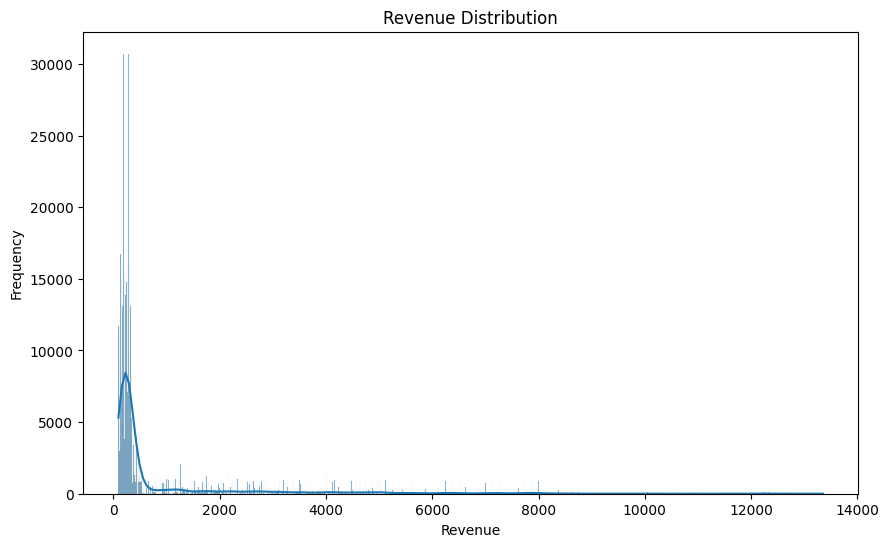

In [77]:
# Plot the Revenue distribution graph
plt.figure(figsize=(10, 6))
sns.histplot(df['Revenue'], kde=True)
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

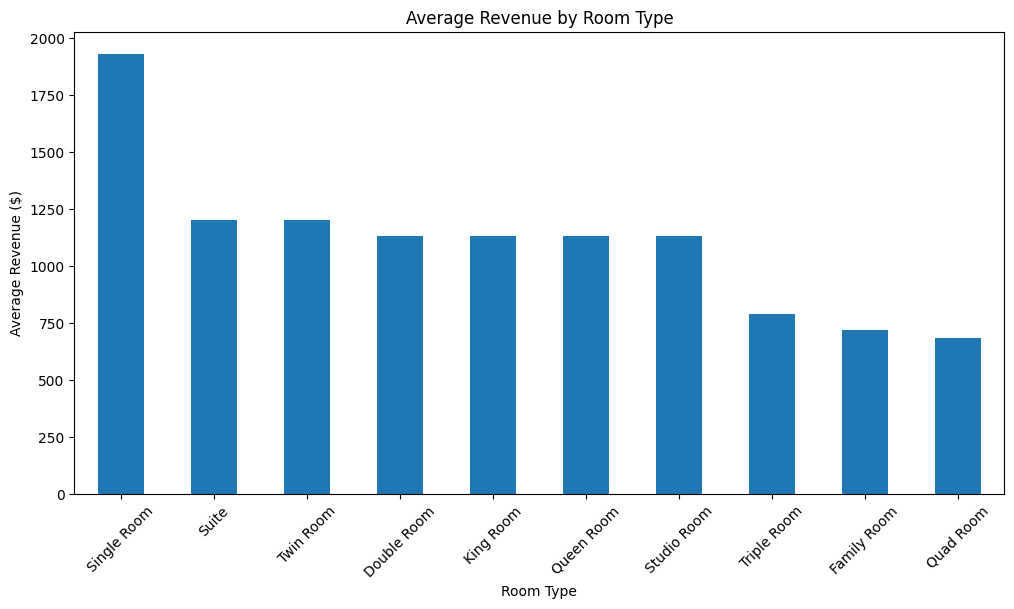

In [78]:
# Average revenue by room type
room_type_revenue = df.groupby('Room_Type')['Revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
room_type_revenue.plot(kind='bar')
plt.title('Average Revenue by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

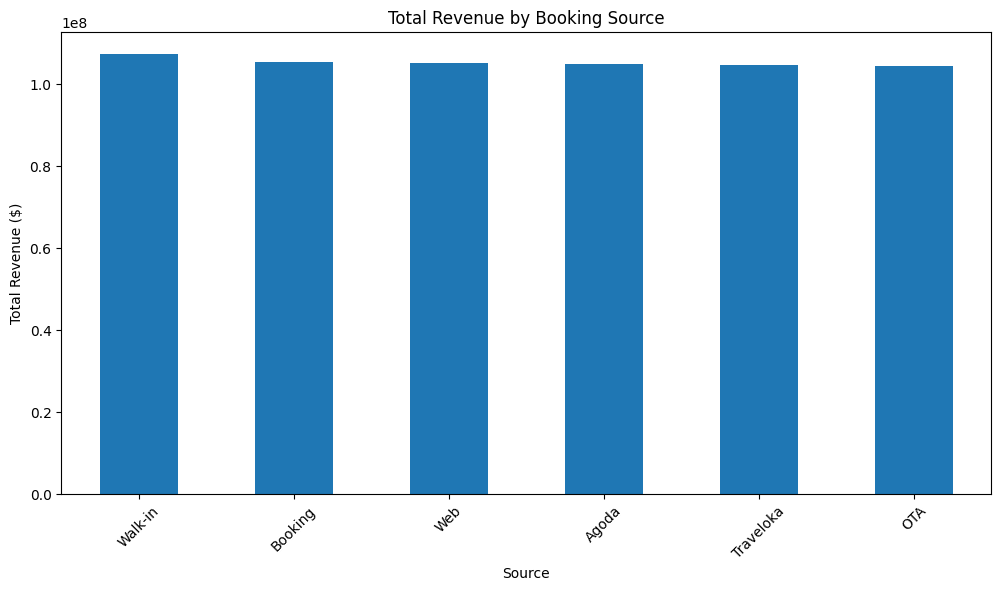

In [79]:
# Total revenue by booking source
source_revenue = df.groupby('Source')['Revenue'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
source_revenue.plot(kind='bar')
plt.title('Total Revenue by Booking Source')
plt.xlabel('Source')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.show()

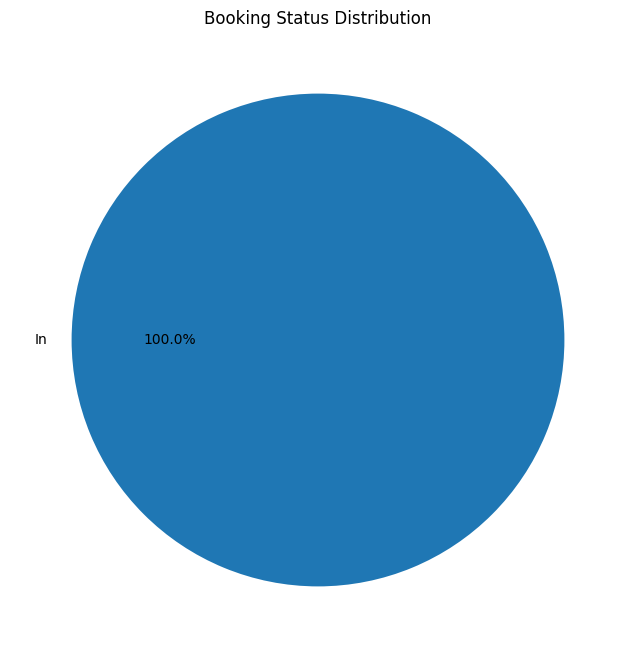

In [80]:
# Booking status distribution
status_distribution = df['Status'].value_counts(normalize=True)
plt.figure(figsize=(8, 8))
plt.pie(status_distribution, labels=status_distribution.index, autopct='%1.1f%%')
plt.title('Booking Status Distribution')
plt.show()

# Data Processing

In [81]:
print("Number of null values before processing:")
print(df.isnull().sum())

Number of null values before processing:
Reservation_Number                      0
Name                                    0
Email                                   0
Phone_Number                            0
Mobile                                  0
Gender                                  0
Date_of_Birth                           0
Third_Party_Confirmation_Number         0
Type_of_Document                        0
Document_Number                         0
Document_Issue_Date                     0
Document_Issuing_Country                0
Document_Expiration_Date                0
Nationality                             0
Street_Address                          0
Apt_suite_floor                    704640
City                               175012
State                                   0
Postal_ZIPCode                      96444
Adults                                  0
Children                                0
Room_Number                             0
Room_Price                         

In [82]:
# Remove unnecessary columns for revenue prediction
columns_to_drop = ['Reservation_Number', 'Name', 'Email', 'Phone_Number', 'Mobile', 'Third_Party_Confirmation_Number',
                   'Document_Number', 'Street_Address', 'Apt_suite_floor', 'URL', 'Cancelation_Date']
df = df.drop(columns=columns_to_drop)

In [83]:
# Handle null values for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

In [84]:
# Handle null values for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

In [85]:
print("\nNumber of null values after processing:")
print(df.isnull().sum())


Number of null values after processing:
Gender                      0
Date_of_Birth               0
Type_of_Document            0
Document_Issue_Date         0
Document_Issuing_Country    0
Document_Expiration_Date    0
Nationality                 0
City                        0
State                       0
Postal_ZIPCode              0
Adults                      0
Children                    0
Room_Number                 0
Room_Price                  0
Amount_Paid                 0
Checkin_Date                0
Checkout_Date               0
Nights                      0
Room_Type                   0
Credit_Card_Type            0
Reservation_Date            0
Source                      0
Status                      0
Guest_Status                0
Cancelation_fee             0
Origin                      0
Property                    0
Brand                       0
Rating                      0
Room_Amenities              0
Property_Country            0
Property_City               0

In [86]:
# Convert date columns to datetime
date_columns = ['Date_of_Birth', 'Document_Issue_Date', 'Document_Expiration_Date', 'Checkin_Date', 'Checkout_Date', 'Reservation_Date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [87]:
# Encode categorical variables
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

print("\nDataset information after processing:")
print(df.info())


Dataset information after processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704640 entries, 0 to 704639
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Gender                    704640 non-null  int64  
 1   Date_of_Birth             704640 non-null  int64  
 2   Type_of_Document          704640 non-null  int64  
 3   Document_Issue_Date       704640 non-null  int64  
 4   Document_Issuing_Country  704640 non-null  int64  
 5   Document_Expiration_Date  704640 non-null  int64  
 6   Nationality               704640 non-null  int64  
 7   City                      704640 non-null  int64  
 8   State                     704640 non-null  int64  
 9   Postal_ZIPCode            704640 non-null  int64  
 10  Adults                    704640 non-null  float64
 11  Children                  704640 non-null  float64
 12  Room_Number               704640 non-null  float64
 13  Room_

# Select feature

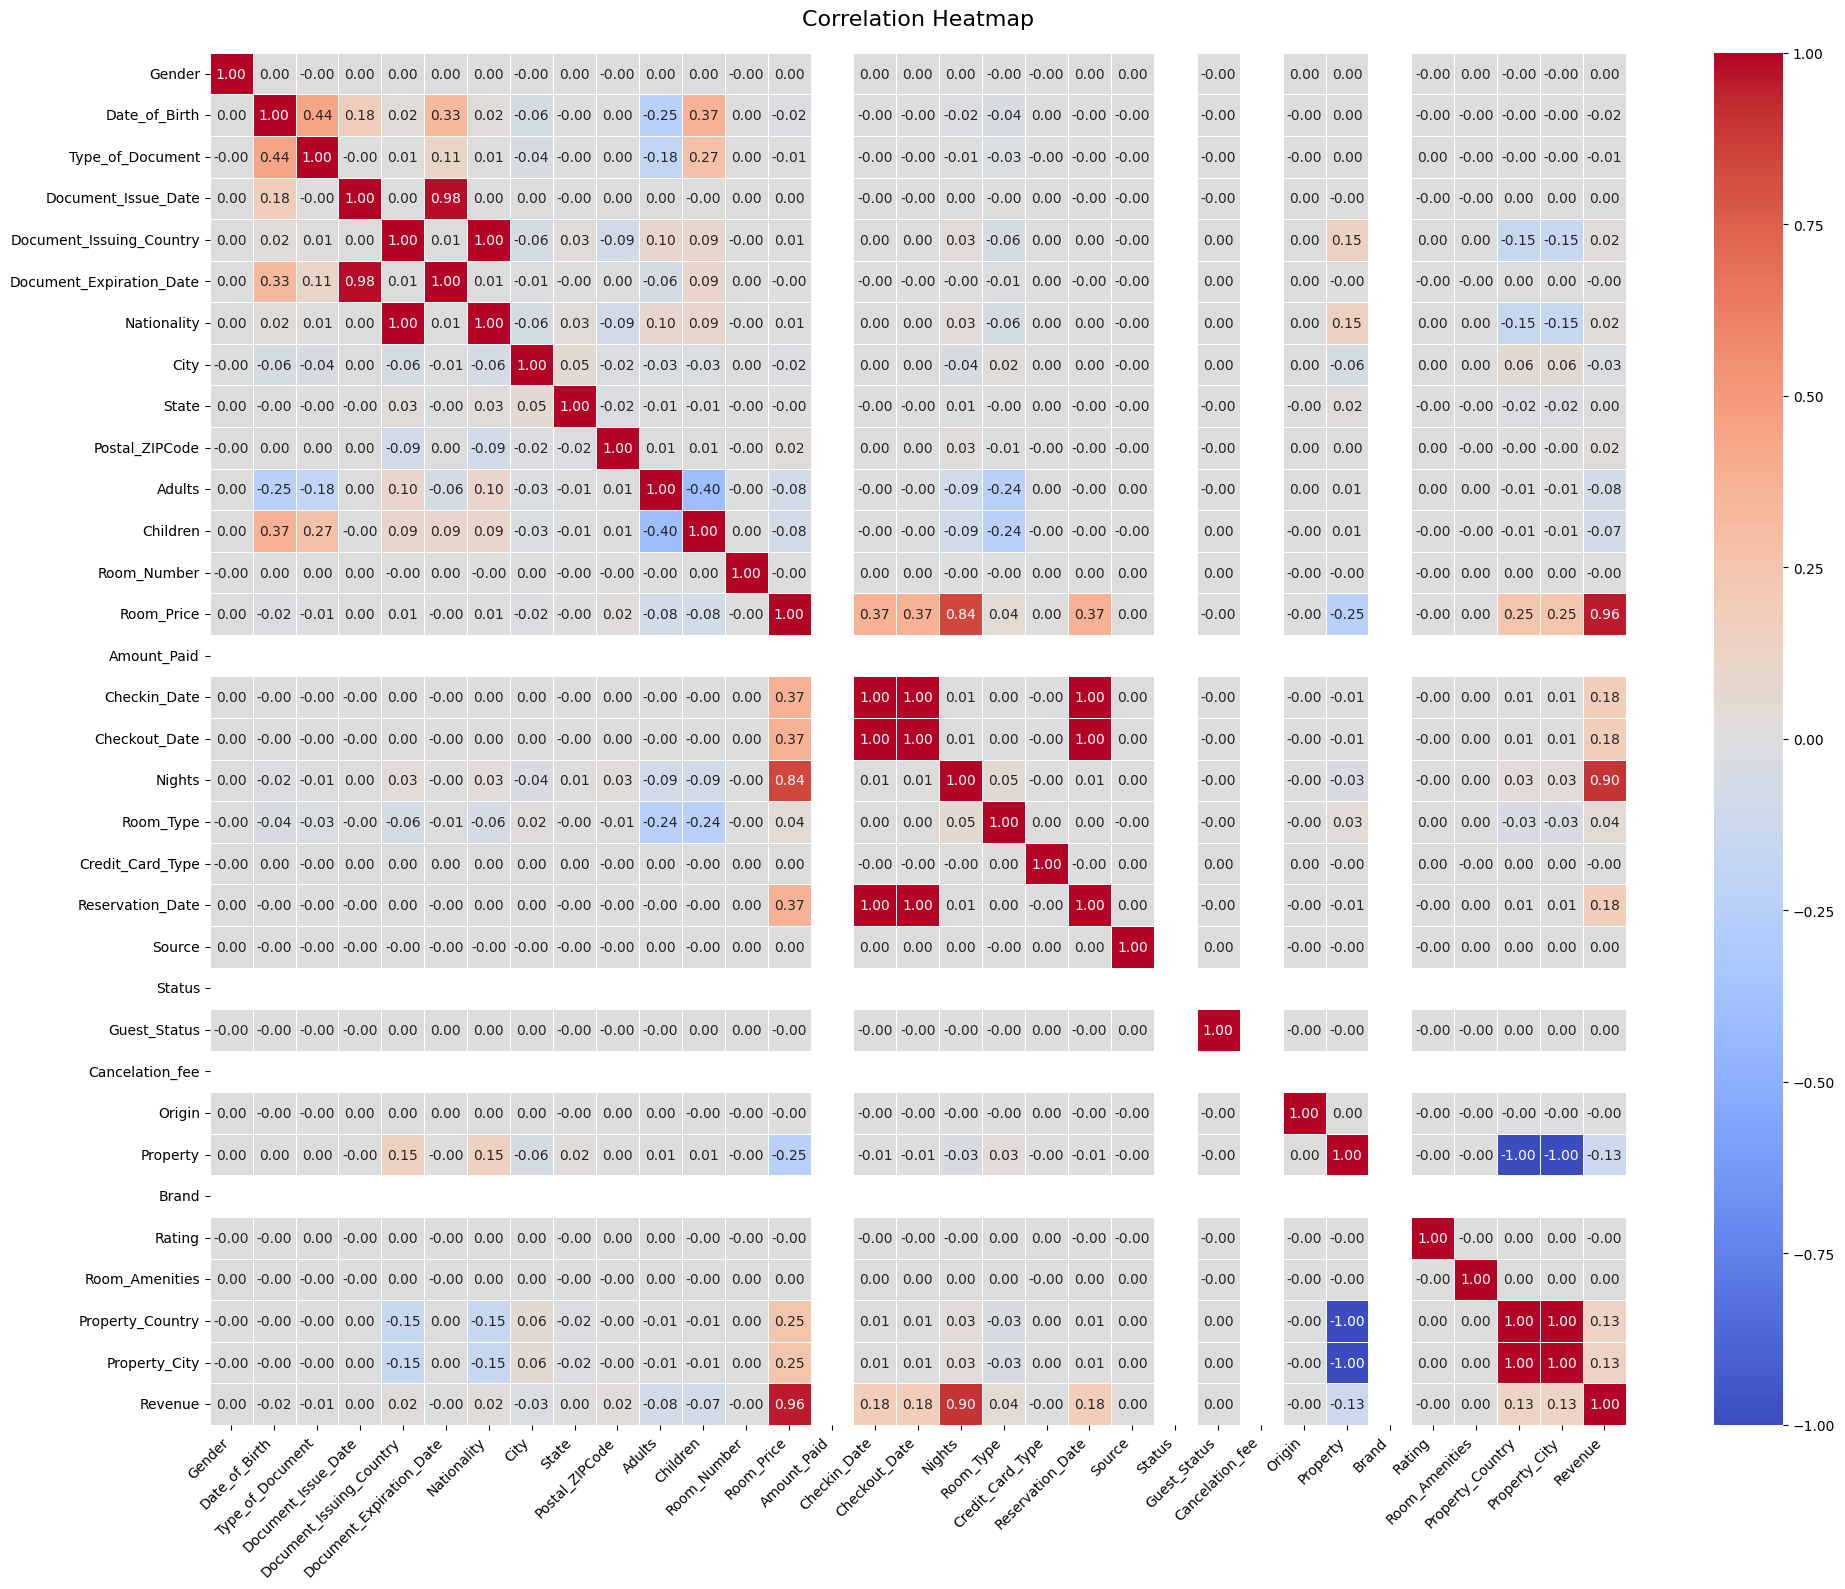

In [88]:
# Select numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [89]:
# Select features based on correlation with target variable 'Accommodation_Total'
target_correlations = abs(correlation_matrix['Revenue']).sort_values(ascending=False)
selected_features = target_correlations[target_correlations > 0.03].index.tolist()
selected_features.remove('Revenue')  # Remove target variable from features

print("Selected features based on correlation:")
print(selected_features)

Selected features based on correlation:
['Room_Price', 'Nights', 'Checkout_Date', 'Checkin_Date', 'Reservation_Date', 'Property', 'Property_City', 'Property_Country', 'Adults', 'Children', 'Room_Type']


In [90]:
# Add some features based on domain knowledge
numeric_features = ['Room_Price', 'Nights', 'Adults', 'Children', 'Checkout_Date', 'Checkin_Date', 'Reservation_Date']
categorical_features = ['Property', 'Property_City', 'Property_Country', 'Room_Type', 'Source', 'Status', 'Guest_Status']
features = numeric_features + categorical_features

# Split the data set

In [91]:
X = df[features]
y = df['Revenue']


In [92]:
# Chia thành tập train, validation và test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Data Preparation

In [93]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# For features that are integers but should be treated as categories
integer_categorical_features = ['Property', 'Property_City', 'Property_Country', 'Room_Type', 'Source', 'Status', 'Guest_Status']
numeric_features = [col for col in numeric_features if col not in integer_categorical_features]
categorical_features += integer_categorical_features

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)



Numeric features: ['Room_Price', 'Nights', 'Adults', 'Children', 'Checkout_Date', 'Checkin_Date', 'Reservation_Date']
Categorical features: ['Property', 'Property_City', 'Property_Country', 'Room_Type', 'Source', 'Status', 'Guest_Status']


In [94]:
# Update the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Update the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Model Building and Train models

In [95]:
# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"\n{model_name} Results:")
    print(f"Training R2 Score: {train_score:.4f}")
    print(f"Validation R2 Score: {val_score:.4f}")
    print(f"Validation RMSE: {rmse:.2f}")
    return model, val_score

In [96]:
# Prepare data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# List to store model results
model_results = []

In [97]:
# Linear Regression
lr_model = LinearRegression()
lr_model, lr_score = evaluate_model(lr_model, X_train_processed, y_train, X_val_processed, y_val, "Linear Regression")
model_results.append(("Linear Regression", lr_score))


Linear Regression Results:
Training R2 Score: 0.9697
Validation R2 Score: 0.9699
Validation RMSE: 290.70


In [98]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5,
                                 min_samples_leaf=2, max_features='sqrt', random_state=42)
rf_model, rf_score = evaluate_model(rf_model, X_train_processed, y_train, X_val_processed, y_val, "Random Forest")
model_results.append(("Random Forest", rf_score))


Random Forest Results:
Training R2 Score: 0.9925
Validation R2 Score: 0.9924
Validation RMSE: 146.53


In [99]:
# Elastic Net
en_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
en_model, en_score = evaluate_model(en_model, X_train_processed, y_train, X_val_processed, y_val, "Elastic Net")
model_results.append(("Elastic Net", en_score))


Elastic Net Results:
Training R2 Score: 0.8981
Validation R2 Score: 0.8983
Validation RMSE: 534.83


# Model Selection and Evaluation

In [100]:
# Prepare test data
X_test_processed = preprocessor.transform(X_test)

# Function to evaluate model on test set
def evaluate_model_test(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    test_score = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\n{model_name} Test Results:")
    print(f"Test R2 Score: {test_score:.4f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    return test_score, test_rmse


In [101]:
# Evaluate models on test set
lr_test_score, lr_test_rmse = evaluate_model_test(lr_model, X_test_processed, y_test, "Linear Regression")
rf_test_score, rf_test_rmse = evaluate_model_test(rf_model, X_test_processed, y_test, "Random Forest")
en_test_score, en_test_rmse = evaluate_model_test(en_model, X_test_processed, y_test, "Elastic Net")


Linear Regression Test Results:
Test R2 Score: 0.9699
Test RMSE: 291.51

Random Forest Test Results:
Test R2 Score: 0.9924
Test RMSE: 146.74

Elastic Net Test Results:
Test R2 Score: 0.8976
Test RMSE: 537.72


In [102]:
# Select the best model
best_model = max([lr_model, rf_model, en_model], key=lambda m: m.score(X_test_processed, y_test))
print(f"\nBest model: {type(best_model).__name__}")


Best model: RandomForestRegressor


In [103]:
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

# Predict revenue for the next month

In [114]:

# Predict revenue for the next month

# let's find the last date in our dataset
last_date = df['Checkin_Date'].max()

# Calculate the start and end dates for the next month
next_month_start = last_date + pd.Timedelta(days=1)
next_month_end = next_month_start + pd.Timedelta(days=30)

# Create a date range for the next month
next_month_dates = pd.date_range(start=next_month_start, end=next_month_end, freq='D')

# Create a DataFrame for the next month
next_month_df = pd.DataFrame({'Checkin_Date': next_month_dates})

# Add other necessary features
next_month_df['Property'] = df['Property'].mode()[0]  # Most common property
next_month_df['Room_Type'] = df['Room_Type'].mode()[0]  # Most common room type
next_month_df['Nights'] = df['Nights'].mean()  # Average number of nights
next_month_df['Adults'] = df['Adults'].mean()  # Average number of adults
next_month_df['Children'] = df['Children'].mean()  # Average number of children
next_month_df['Room_Price'] = df['Room_Price'].mean()  # Average room price
next_month_df['Source'] = df['Source'].mode()[0]  # Most common booking source
next_month_df['Status'] = df['Status'].mode()[0]  # Most common status
next_month_df['Guest_Status'] = df['Guest_Status'].mode()[0]  # Most common guest status
next_month_df['Property_City'] = df['Property_City'].mode()[0]  # Most common city
next_month_df['Property_Country'] = df['Property_Country'].mode()[0]  # Most common country

# Add missing columns: Checkout_Date and Reservation_Date
next_month_df['Checkout_Date'] = next_month_df['Checkin_Date'] + pd.Timedelta(days=next_month_df['Nights'].mean())
next_month_df['Reservation_Date'] = next_month_df['Checkin_Date'] - pd.Timedelta(days=30)  # Assume reservations are made 30 days in advance on average

# Ensure all necessary columns are present
for col in features:
    if col not in next_month_df.columns:
        print(f"Warning: Column '{col}' is missing in next_month_df. Adding it with default values.")
        next_month_df[col] = df[col].mode()[0] if df[col].dtype == 'object' else df[col].mean()

# Convert datetime columns to datetime type
for col in datetime_features:
    next_month_df[col] = pd.to_datetime(next_month_df[col])

# Preprocess the next month data
next_month_processed = preprocessor.transform(next_month_df[features])

# Make predictions using the best model
next_month_predictions = best_model.predict(next_month_processed)

# Add predictions to the next_month_df
next_month_df['Predicted_Revenue'] = next_month_predictions

# Calculate total predicted revenue for the next month
total_predicted_revenue = next_month_predictions.sum()

print(f"Total predicted revenue for the next month: ${total_predicted_revenue:.2f}")

Total predicted revenue for the next month: $21513.48


# Visualize results

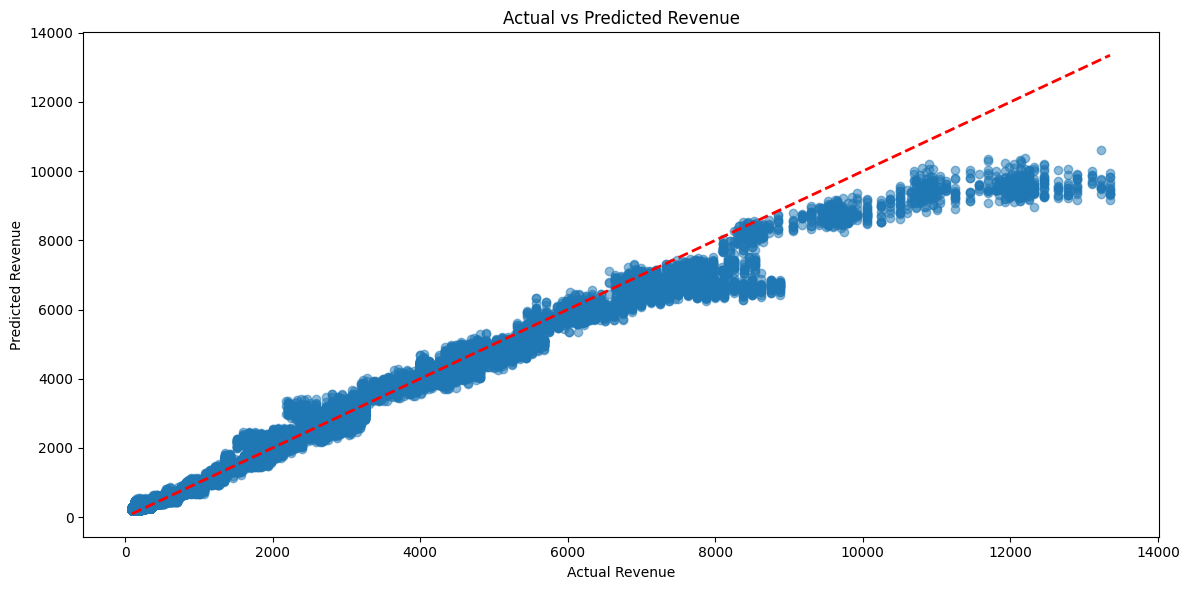

In [112]:
# Plot actual vs predicted revenue (using test set)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, best_model.predict(X_test_processed), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.tight_layout()
plt.show()


# Conclusion and Recommendations

1. The model predicts a total revenue of $21513.48 for the next month.
2. Recommendations:
   - Focus on optimizing room prices and length of stay to maximize revenue.
   - Analyze booking patterns to identify peak periods and adjust marketing strategies.
   - Consider implementing dynamic pricing based on demand forecasts.
   - Improve guest experience to encourage longer stays and repeat bookings.
   - Monitor and optimize the performance of different booking sources.
3. Future improvements:
   - Incorporate external factors such as seasonality, events, and economic indicators.
   - Implement time series analysis for more accurate trend predictions.
   - Regularly retrain the model with new data to maintain accuracy.
   - Consider ensemble methods or more advanced algorithms for potentially better performance.